In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch, helpers

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set(font="WenQuanYi Micro Hei", font_scale=1.5)
plt.style.use('ggplot')

import psycopg2


def connect():
    return psycopg2.connect(
        database='sharecar',
        user='derekhe',
        password='',
        host='localhost',
        port='5432')


conn = connect()

In [2]:
all_plates = [
    "京", "津", "沪", "冀", "豫", "云", "辽", "黑", "湘", "皖", "鲁", "新", "苏", "浙", "赣",
    "鄂", "桂", "甘", "晋", "蒙", "陕", "吉", "闽", "贵", "粤", "川", "青", "藏", "琼", "宁",
    "渝"
]

In [3]:
#车数量
df = pd.read_sql("SELECT COUNT(DISTINCT(plate_num)) from sharecar_20180126",
                 conn)
df['count']

0    10327
Name: count, dtype: int64

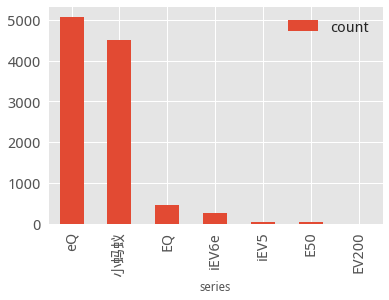

In [4]:
#车类型
df = pd.read_sql("select t.series, count(plate_num) as count from (select plate_num, series from sharecar_20180125 group by plate_num, series) as t group by series order by count desc", conn)
df.plot.bar(x='series')
df.to_json("./analysis/car_types.json", force_ascii=False, orient='records')

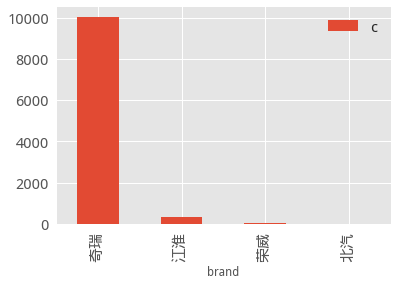

In [5]:
#车商类型
df = pd.read_sql(
    "select t.brand, count(plate_num) as c from (select plate_num, brand from sharecar_20180125 group by plate_num, brand) as t group by brand order by c desc",
    conn)
df.plot.bar(x='brand')
df.to_json("./analysis/brands.json", force_ascii=False, orient='records')

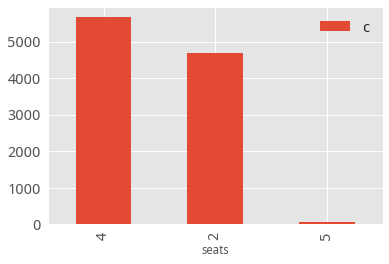

In [6]:
#座位
df = pd.read_sql(
    "select t.seats, count(plate_num) as c from (select plate_num, seats from sharecar_20180125 group by plate_num, seats) as t group by seats order by c desc",
    conn)
df.plot.bar(x='seats')
df.to_json("./analysis/seats.json", force_ascii=False, orient='records')

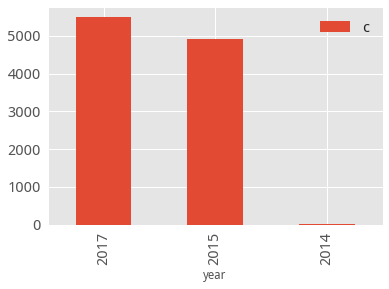

In [7]:
#购车年代
df = pd.read_sql(
    "select t.year, count(plate_num) as c from (select plate_num, substring(year from 0 for 5) as year from sharecar_20180125 group by plate_num, year) as t group by year order by c desc",
    conn)
df.plot.bar(x='year')
df.to_json("./analysis/year.json", force_ascii=False, orient='records')

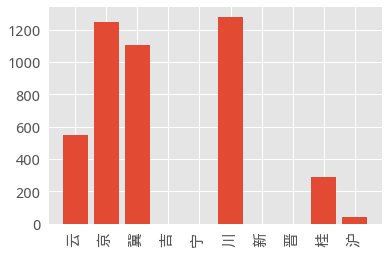

In [8]:
#各省车辆分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(plate_num)) from sharecar_20180126 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

df_car = pd.DataFrame.from_records(list(zip(x,y)), columns=['province','count'])
df_car = df_car[df_car['count']!=0]
df_car.to_json("./analysis/car_distrubution.json", force_ascii=False, orient='records')

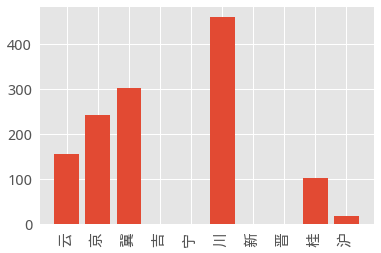

In [9]:
#各省停车场分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(parking_name)) from sharecar_20180126 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

df_park = pd.DataFrame.from_records(list(zip(x,y)), columns=['province','count'])
df_park = df_park[df_park['count']!=0]
df_park.to_json("./analysis/park_distrubution.json", force_ascii=False, orient='records')

In [10]:
df_average_cars_per_park = (df_car.set_index("province") / df_park.set_index("province"))
df_average_cars_per_park['province'] = df_average_cars_per_park.index
df_average_cars_per_park.to_json("./analysis/average_cars_per_park.json", force_ascii=False, orient='records')
df_average_cars_per_park

,count,province
province,,
京,2.825726,京
津,3.392157,津
沪,2.352941,沪
云,3.519231,云
湘,3.584906,湘
皖,4.709677,皖
鲁,2.939394,鲁
苏,3.361446,苏
浙,2.973262,浙


In [11]:
import math


x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0  # 长半轴
ee = 0.00669342162296594323  # 偏心率平方
def gcj02_to_bd09(lng, lat):
    """
    火星坐标系(GCJ-02)转百度坐标系(BD-09)
    谷歌、高德——>百度
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]


#停车场位置
df = pd.read_sql(
        "SELECT position[0] as lat, position[1] as lon, parking_name from sharecar_20180126", conn)
r = 1000

df = df.drop_duplicates(subset=['parking_name'])

def convert(x):
    converted = gcj02_to_bd09(x[0],x[1])
    return converted[0], converted[1]

df['location'] = df.apply(convert, axis=1)

df.to_json("./analysis/park_locations.json", force_ascii=False, orient='records')
df

,lat,lon,parking_name,location
0,118.836664,32.015580,四方新村四方巷,"(118.84317794229283, 32.021453138013044)"
2,116.360600,40.073533,国风美唐地面停车场,"(116.36715032947208, 40.07936547446265)"
6,103.654369,30.983092,山南花园底商停车位*（城乡产权中心旁）,"(103.66086564514839, 30.989167771163018)"
9,108.953822,34.215215,长庆坊北门地面停车场,"(108.9602384210776, 34.22152939387631)"
16,117.691423,39.004756,新港路喆啡酒店门前停车场,"(117.69791857059735, 39.01078352574869)"
18,119.450130,25.982433,马尾船政文化博物馆,"(119.45669498426152, 25.988120809702732)"
20,113.007763,28.119652,亚商国际地面前坪停车场【请勿乱停乱放】,"(113.01428964103192, 28.125616903311048)"
24,113.111793,23.030786,岭南天地P4停车场,"(113.11834044056219, 23.036507376962643)"
30,102.828911,24.833557,月华街路边停车位（云南艺术学院北门外）,"(102.83534247245659, 24.83981318058035)"
33,119.256668,26.067994,融侨观邸（前后两个停车场都可以使用）,"(119.26316027994828, 26.074120228340792)"


In [ ]:
all_tables = [
    "sharecar_20171001", "sharecar_20171002", "sharecar_20171003",
    "sharecar_20171004", "sharecar_20171005", "sharecar_20171006",
    "sharecar_20171007", "sharecar_20171008", "sharecar_20171009",
    "sharecar_20171010", "sharecar_20171011", "sharecar_20171012",
    "sharecar_20171013", "sharecar_20171014", "sharecar_20171015",
    "sharecar_20171016", "sharecar_20171017", "sharecar_20171018",
    "sharecar_20171019", "sharecar_20171020", "sharecar_20171021",
    "sharecar_20171022", "sharecar_20171024", "sharecar_20171025",
    "sharecar_20171026", "sharecar_20171027", "sharecar_20171028",
    "sharecar_20171029", "sharecar_20171030", "sharecar_20171031",
    "sharecar_20171101", "sharecar_20171102", "sharecar_20171103",
    "sharecar_20171104", "sharecar_20171105", "sharecar_20171106",
    "sharecar_20171107", "sharecar_20171108", "sharecar_20171109",
    "sharecar_20171110", "sharecar_20171111", "sharecar_20171112",
    "sharecar_20171113", "sharecar_20171114", "sharecar_20171115",
    "sharecar_20171116", "sharecar_20171117", "sharecar_20171118",
    "sharecar_20171119", "sharecar_20171120", "sharecar_20171121",
    "sharecar_20171122", "sharecar_20171123", "sharecar_20171124",
    "sharecar_20171125", "sharecar_20171126", "sharecar_20171127",
    "sharecar_20171128", "sharecar_20171129", "sharecar_20171130",
    "sharecar_20171201", "sharecar_20171202", "sharecar_20171203",
    "sharecar_20171204", "sharecar_20171205", "sharecar_20171206",
    "sharecar_20171207", "sharecar_20171208", "sharecar_20171209",
    "sharecar_20171210", "sharecar_20171211", "sharecar_20171212",
    "sharecar_20171213", "sharecar_20171214", "sharecar_20171215",
    "sharecar_20171216", "sharecar_20171217", "sharecar_20171218",
    "sharecar_20171219", "sharecar_20171220", "sharecar_20171221",
    "sharecar_20171222", "sharecar_20171223", "sharecar_20171224",
    "sharecar_20171225", "sharecar_20171226", "sharecar_20171227",
    "sharecar_20171228", "sharecar_20171229", "sharecar_20171230",
    "sharecar_20171231", "sharecar_20180101", "sharecar_20180102",
    "sharecar_20180103", "sharecar_20180104", "sharecar_20180105",
    "sharecar_20180106", "sharecar_20180107", "sharecar_20180108",
    "sharecar_20180109", "sharecar_20180110", "sharecar_20180111",
    "sharecar_20180112", "sharecar_20180113", "sharecar_20180114",
    "sharecar_20180115", "sharecar_20180116"
]

In [27]:
#停车场数量增长
parks = []
dates = []
for table in all_tables:
    if table[-1] == '2':        
        print(table)
        df = pd.read_sql(
                "select count(distinct(parking_name)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(table[9:])
df = pd.DataFrame(parks, columns = ['parking_count'])
df['date'] = dates
df.to_json("./analysis/parking_increase.json", force_ascii=False, orient='records')
df

sharecar_20171002
sharecar_20171012
sharecar_20171022
sharecar_20171102
sharecar_20171112
sharecar_20171122
sharecar_20171202
sharecar_20171212
sharecar_20171222
sharecar_20180102
sharecar_20180112


,parking_count,date
0,1929,20171002
1,1985,20171012
2,2070,20171022
3,2201,20171102
4,2287,20171112
5,2377,20171122
6,2492,20171202
7,2565,20171212
8,2722,20171222
9,2766,20180102


In [24]:
#车数量增长
parks = []
dates = []
for table in all_tables:
    if table[-1] == '2':        
        print(table)
        df = pd.read_sql(
                "select count(distinct(plate_num)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(table[9:])
df = pd.DataFrame(parks, columns = ['car_count'])
df['date'] = dates
df.to_json("./analysis/car_increase.json", force_ascii=False, orient='records')
df

sharecar_20171002
sharecar_20171012
sharecar_20171022
sharecar_20171102
sharecar_20171112
sharecar_20171122
sharecar_20171202
sharecar_20171212
sharecar_20171222
sharecar_20180102
sharecar_20180112


,car_count,date
0,8860,20171002
1,9604,20171012
2,9805,20171022
3,10127,20171102
4,10206,20171112
5,10071,20171122
6,9994,20171202
7,10222,20171212
8,10513,20171222
9,10404,20180102


In [13]:
#车数量
df = pd.read_sql("select distinct(plate_num) from sharecar_20180126;", conn)
len(df)

10327

In [28]:
#停车场
df = pd.read_sql("select distinct(parking_name) from sharecar_20180126;", conn)
len(df)

2887

In [15]:
import pandas as pd
import concurrent.futures
import os


def find_parkings(plateNum):
    try:
        filename = "./out/" + plateNum + ".json"
        if os.path.exists(filename):
            return

        with connect() as conn:
            df = None
            sqls = []
            sql = ""
            for t in all_tables:
                sqls.append("""
                select time, parking_name, position, battery from %s where plate_num = '%s'
                """ % (t, plateNum))
            sql = """set max_parallel_workers_per_gather = 2;set enable_seqscan=false;"""
            sql += "UNION ALL".join(sqls)

            df = pd.read_sql(
                sql, conn,
                index_col='time').sort_index().tz_convert("Asia/Shanghai")
            df1 = df.drop_duplicates(keep='first', subset='parking_name')
            df2 = df.drop_duplicates(keep='last', subset='parking_name')
            rst = df1.combine_first(df2)
            rst.to_json(filename, force_ascii=False, date_format='iso', orient='index')
            print(plateNum)
    except Exception as ex:
        print(ex)


executor = concurrent.futures.ProcessPoolExecutor(max_workers=16)
for p in df['plate_num'].values:
    executor.submit(find_parkings, p)

executor.shutdown()

In [16]:
import glob
import os.path

parkings = {}
for file in glob.glob("./out/*.json"):
    key = os.path.basename(file).replace(".json", "")
    df = pd.read_json(file, orient='index')
    if len(df) == 0:
        parkings[key] = 0
        continue
    parkings[key] = len(
        df['parking_name'].drop_duplicates())
parkings

{'湘A3N54D': 44,
 '陕A6015Z': 50,
 '津LAA406': 28,
 '闽DZ810C': 52,
 '京Q6T9K9': 68,
 '粤YRE057': 8,
 '陕A2600Z': 62,
 '津LAK513': 36,
 '云A1P4S2': 72,
 '鲁B79HQ3': 18,
 '京QK89J2': 58,
 '闽AH7Q23': 56,
 '粤YA967S': 42,
 '鄂A87Y3G': 65,
 '鄂A36T5N': 86,
 '川AD00784': 55,
 '鲁B88LF9': 34,
 '闽AD09129': 29,
 '闽AD00030': 19,
 '闽AD01690': 5,
 '云A1P7A5': 71,
 '皖AS7G31': 53,
 '陕A2953Z': 51,
 '京Q9S5E6': 57,
 '京Q2T3K7': 45,
 '陕A8230Z': 42,
 '川AD00941': 57,
 '川A55B4U': 87,
 '津LAK451': 22,
 '京Q6T1K6': 34,
 '湘A7V01M': 3,
 '云A2S5X0': 61,
 '川A027QD': 114,
 '京Q7S8E1': 53,
 '湘A2V52P': 0,
 '川AB075Z': 118,
 '粤A2H8Y9': 61,
 '粤A8H6Y7': 43,
 '粤YPY495': 13,
 '陕A2926Z': 59,
 '陕A8359Z': 54,
 '川A2B10S': 121,
 '琼B0158X': 63,
 '京Q2T9K6': 35,
 '粤A0D0U2': 59,
 '浙B5E7D5': 69,
 '闽DE9D32': 65,
 '皖AS7N75': 48,
 '陕A2183Z': 62,
 '苏AD01036': 29,
 '粤AL24Q0': 41,
 '鲁B5Q63R': 45,
 '津LAF001': 20,
 '川A17N2D': 128,
 '皖AS7G67': 56,
 '粤A5G2R7': 44,
 '粤AL76A0': 54,
 '浙BD00553': 3,
 '琼B0618X': 65,
 '粤YA647V': 42,
 '京Q7S0E6': 18,
 '云A6N3V1': 62,
 '

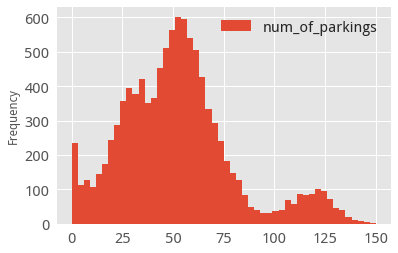

In [38]:
import numpy as np
df = pd.DataFrame.from_dict(parkings, orient='index')
df.columns = ['num_of_parkings']
df.plot.hist(bins=50)

pd.Series(np.histogram(df, bins=50)).to_json("./analysis/num_of_parkings.json", force_ascii=False, orient='records')

In [18]:
df.sort_values(by='num_of_parkings', inplace=True, ascending=False)
plates = df.index.values
plates

array(['川A2A71Y', '川A2A1L5', '川A42YS4', ..., '皖AD02598', '皖AD07558',
       '皖AD08766'], dtype=object)

In [19]:
def export_detail(plate_num):
    df = pd.read_json("./out/" + plate_num + ".json", orient='index')
    if len(df) == 0:
        return df
    
    df = df.tz_localize(
        "UTC").tz_convert("Asia/Shanghai").reset_index()
    df = df[['index', 'parking_name']]
    df.columns = ['t', 'n']
    df['diff'] = (df['t'].shift(-1) - df['t']).fillna(0)
    df['parking'] = df['n'] == df['n'].shift(-1)
    df['start_t'] = df['t']
    df['end_t'] = df['t'].shift(-1)
    df['start_p'] = df['n']
    df['end_p'] = df['n'].shift(-1)
    df = df[['start_t', 'start_p', 'end_t', 'end_p', 'parking',
             'diff']][0:len(df) - 1]
  
    return df

In [20]:
for p in plates:
    filename = "./detail/" + p + ".json"
    if os.path.exists(filename):
        continue
    
    df = export_detail(p)
    df.to_json(filename,
        force_ascii=False,
        date_format='iso',
        orient='records')

In [40]:
import numpy as np

df_using = np.array([])
df_park = np.array([])
for p in plates:
    df = export_detail(p)
    if len(df) == 0:
        continue

    df_using = np.append(
        df_using,
        (df[df['parking'] == False]['diff'] / pd.Timedelta(hours=0.5)).values)
    df_park = np.append(
        df_park,
        (df[df['parking'] == True]['diff'] / pd.Timedelta(hours=0.5)).values)

len(df_using), len(df_park)

(666445, 379137)

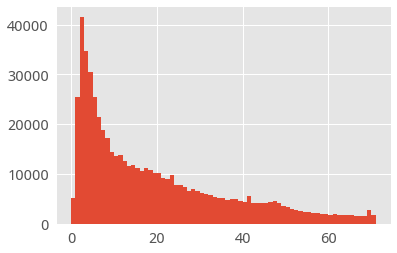

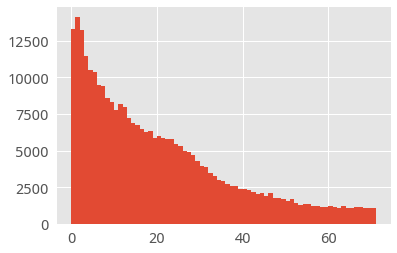

In [41]:
import matplotlib.pyplot as plt

bins=range(0,72,0.5)
plt.hist(df_using, bins=bins)
plt.show()

plt.hist(df_park, bins=bins)
plt.show()

In [42]:
pd.Series(np.histogram(df_using, bins=bins)).to_json("./analysis/using_hist.json", force_ascii=False, orient='records')
pd.Series(np.histogram(df_park, bins=bins)).to_json("./analysis/parking_hist.json", force_ascii=False, orient='records')

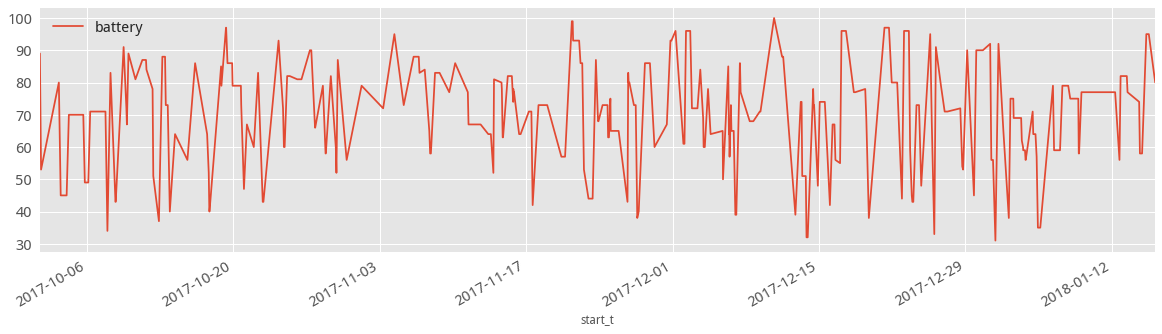

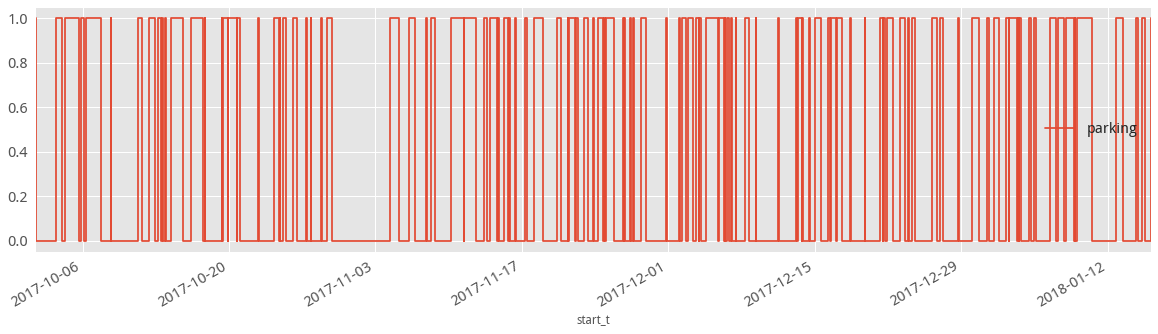

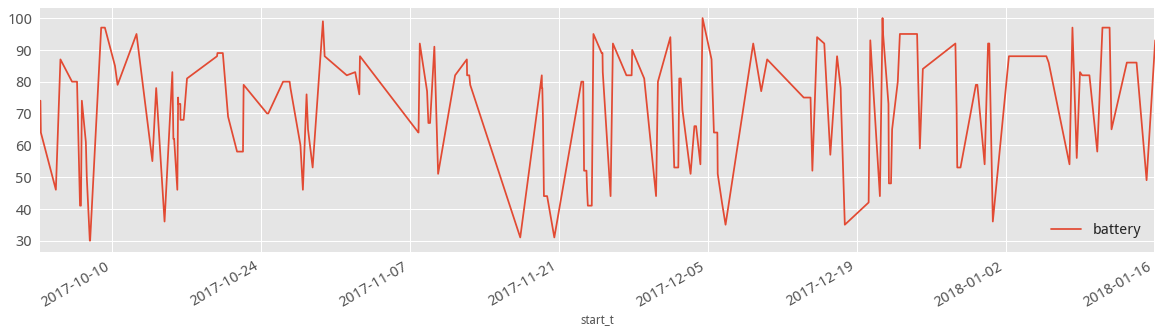

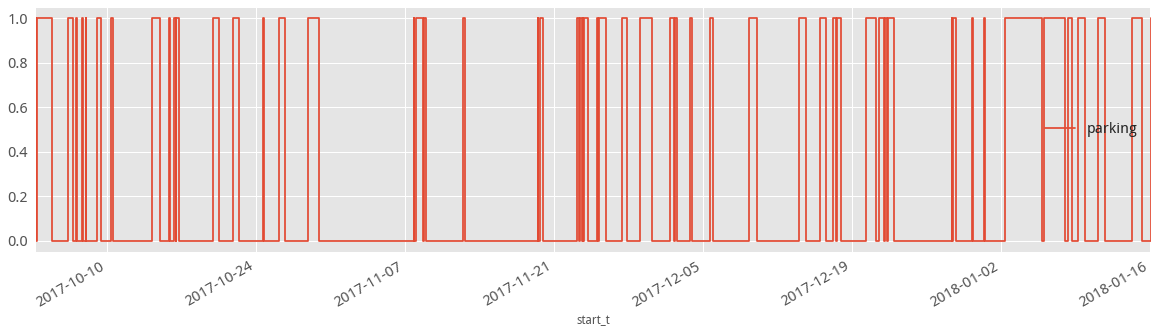

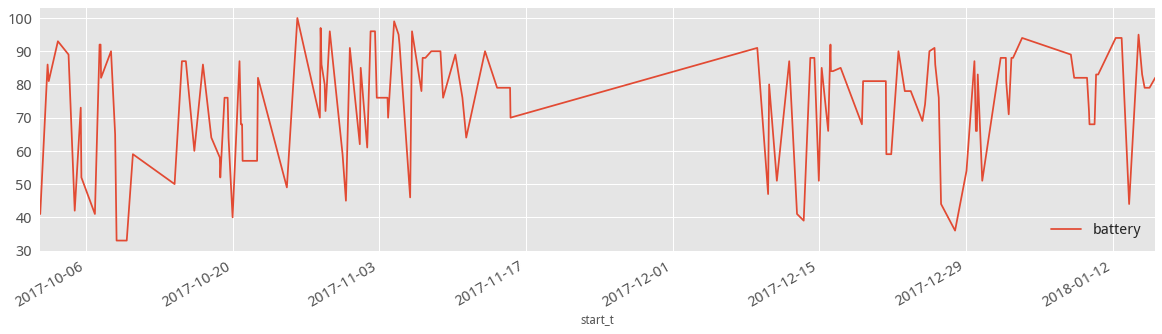

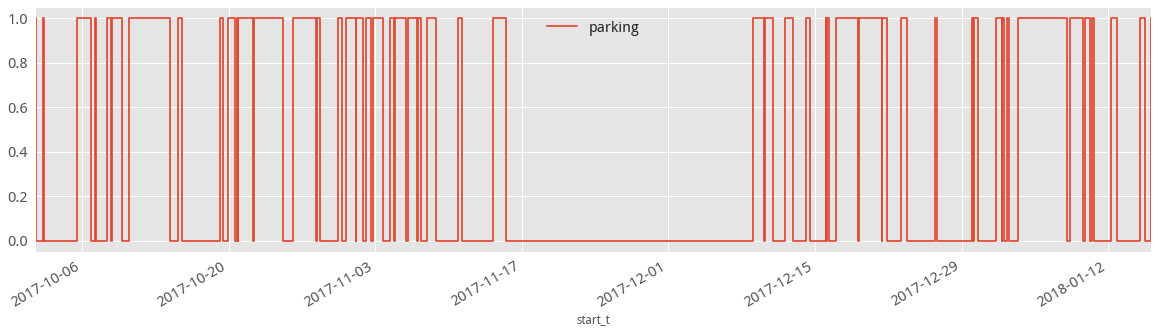

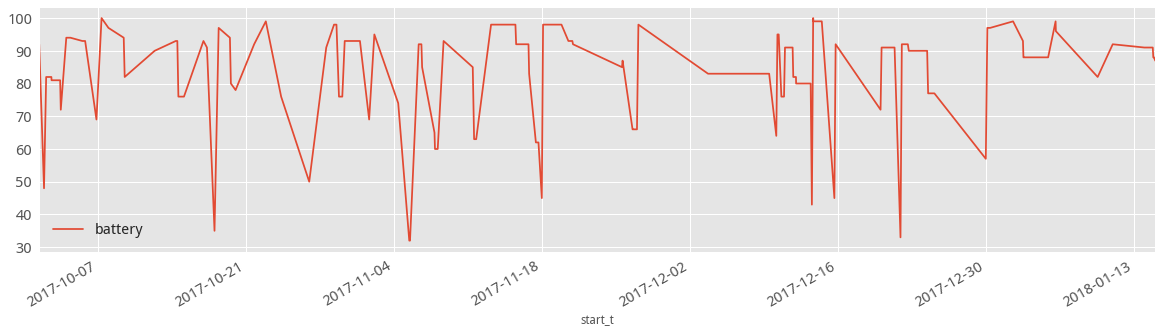

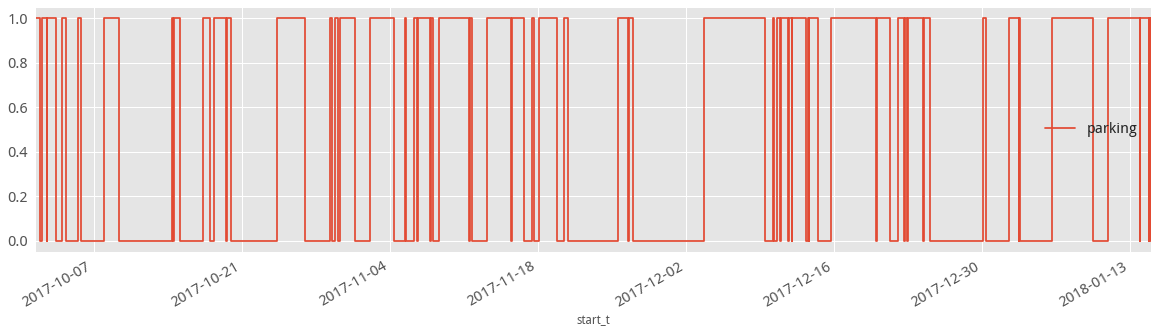

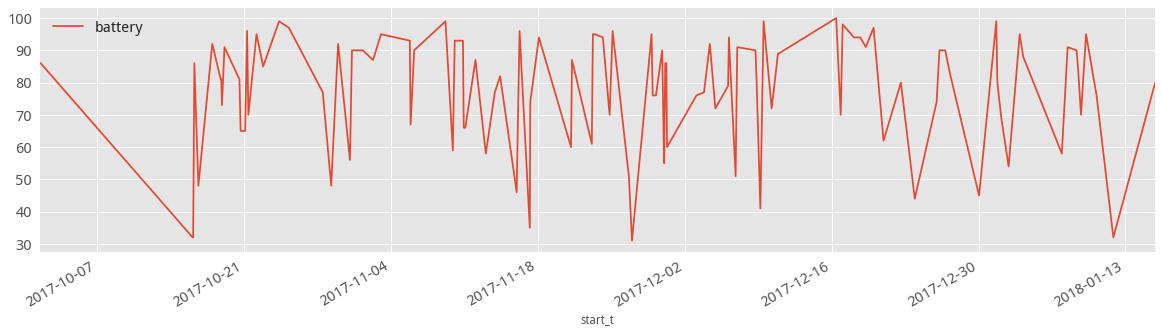

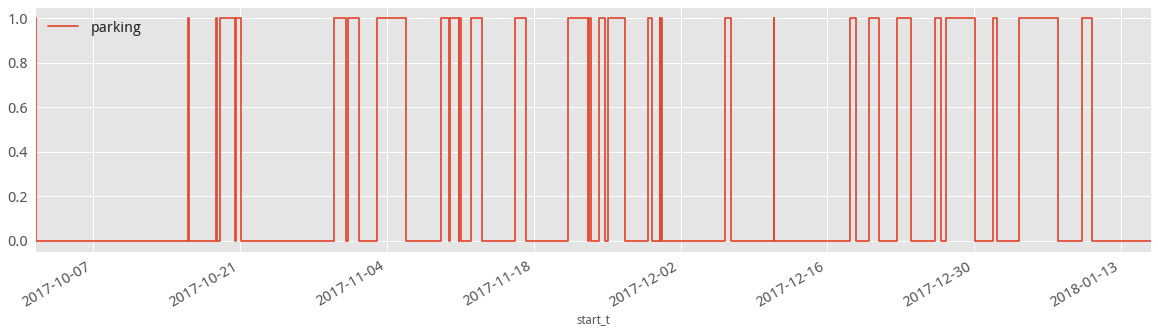

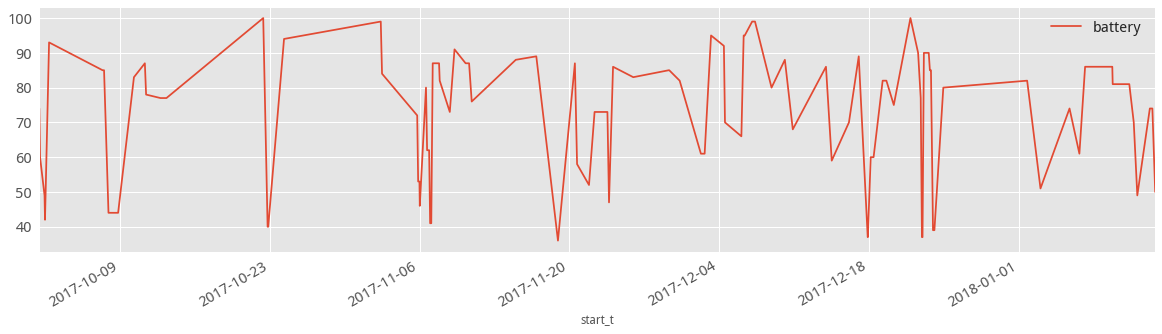

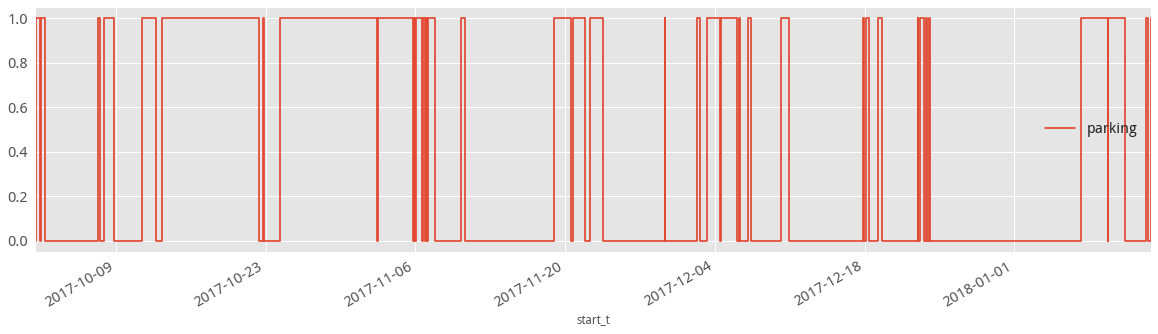

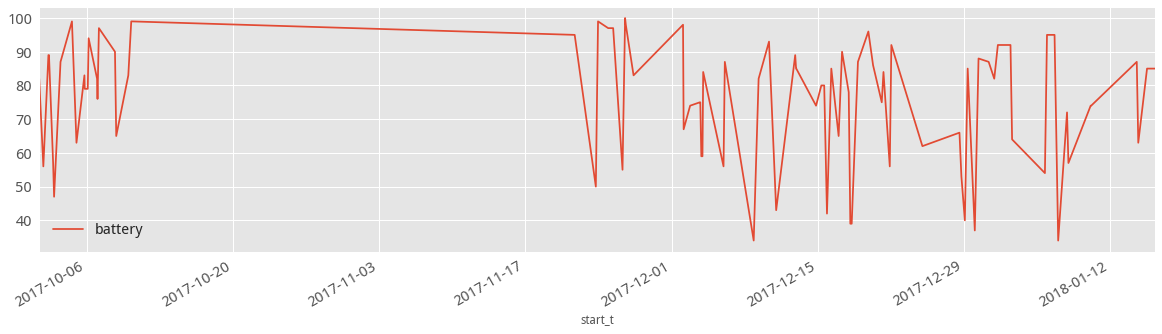

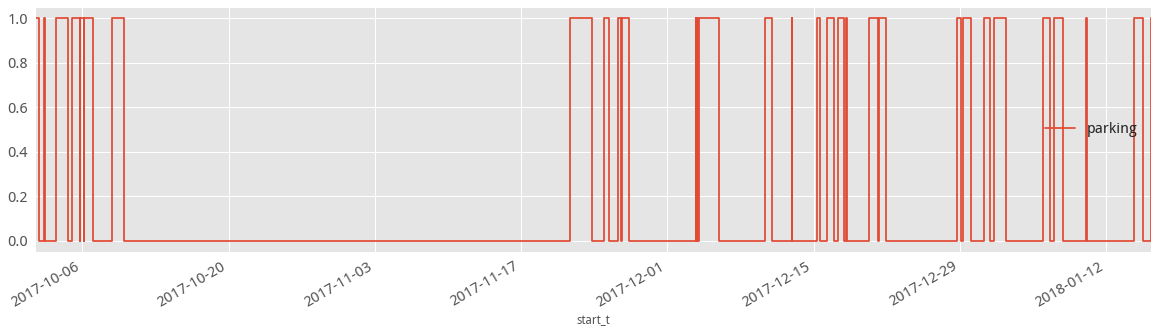

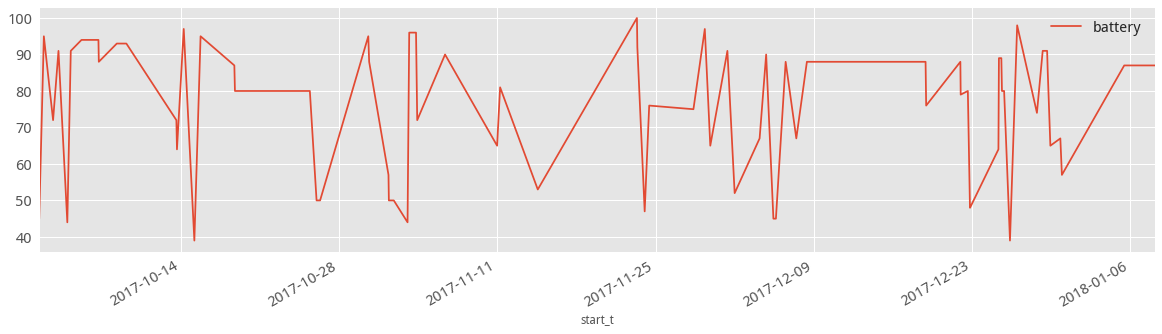

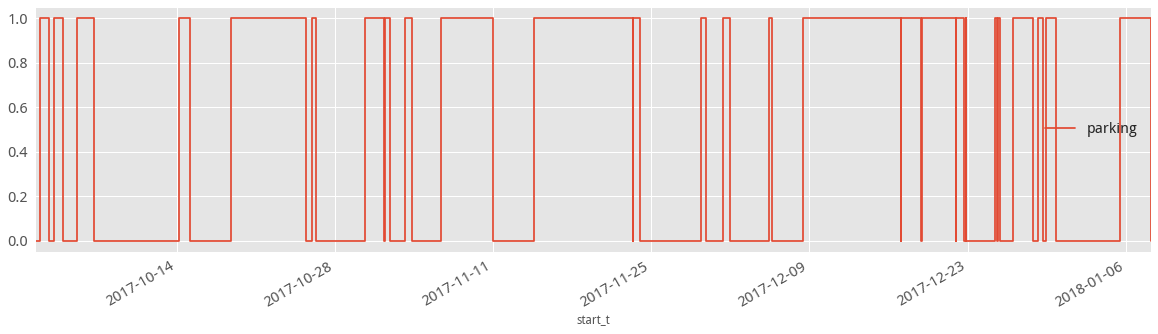

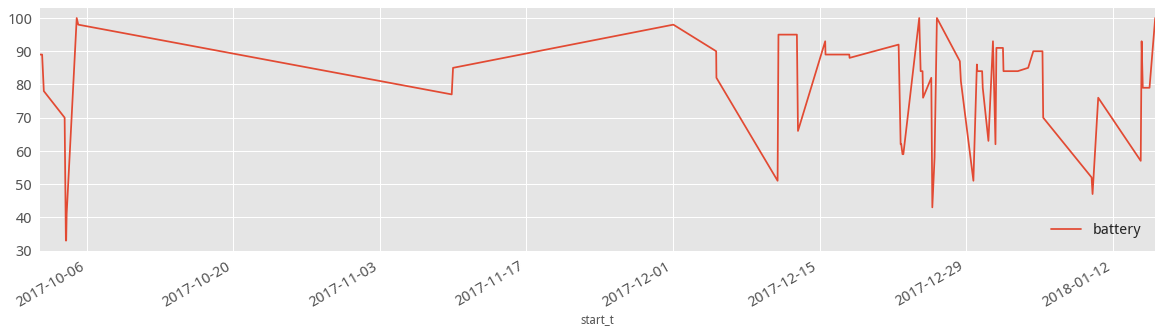

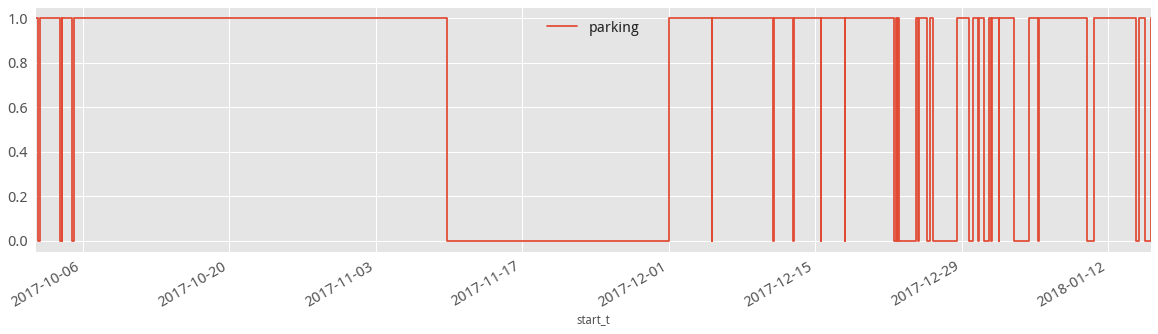

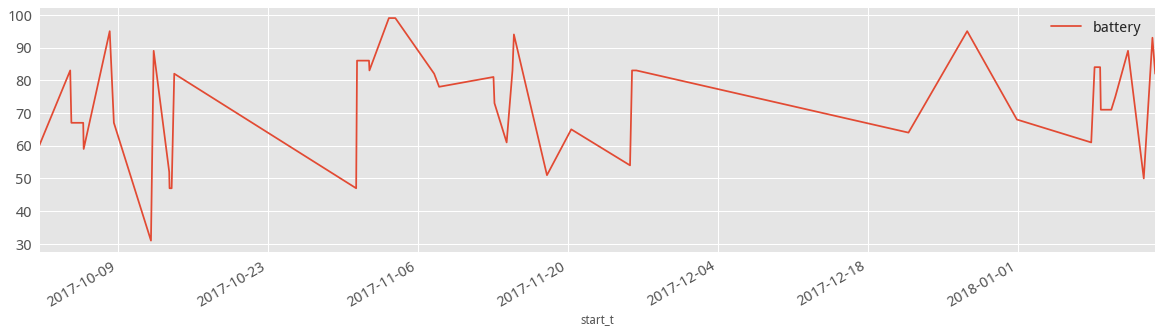

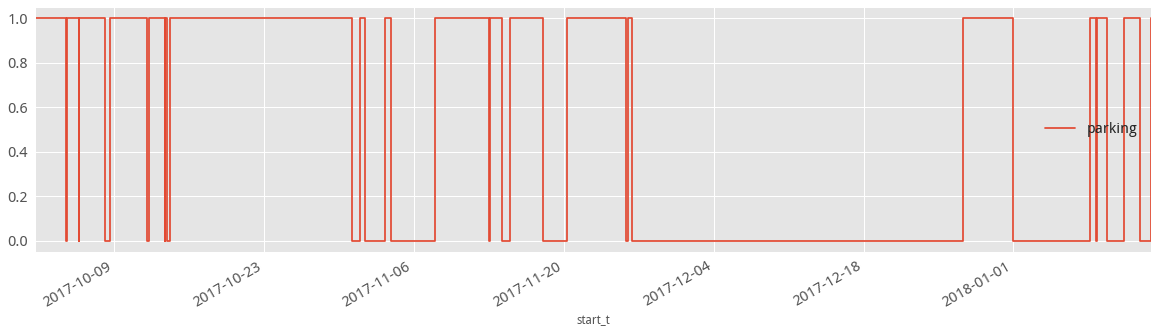

In [24]:
#%matplotlib notebook
%matplotlib inline
for i in [1,1000,2000,3000,4000,5000,6000,7000,8000,9000]:
    plate = plates[i]
    df = pd.read_json("./out/" + plate + ".json", orient='index')
    df = df.tz_localize("UTC").tz_convert("Asia/Shanghai").reset_index()
    df = df[['index', 'parking_name', 'battery','position']]
    df.columns = ['t', 'n', 'battery', 'position']
    df['diff'] = (df['t'].shift(-1) - df['t']).fillna(0)
    df['parking'] = df['n'] == df['n'].shift(-1)
    df['start_t'] = df['t']
    df['end_t'] = df['t'].shift(-1)
    df['start_p'] = df['n']
    df['end_p'] = df['n'].shift(-1)
    df = df[['start_t', 'start_p', 'end_t', 'end_p', 'parking', 'diff',
             'battery','position']][0:len(df) - 1]

    df.plot(x='start_t', y='battery', figsize=[20, 5])
    df.plot(x='start_t', y='parking', figsize=[20, 5], drawstyle="steps-post")
    df.to_json("./analysis/battery_parking_" + plate + ".json", force_ascii=False, orient='records')